**NAME:**
# Intro to Diffusion Models

This notebook is intended to give students a *hands-on* introduction to a basic diffusion model using the *Diffusers* library from *Hugging Face*. The end goal of this notebook is to generate faces by training a diffusion model on the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset.

The work here is based on the [Diffusion Models Class](https://github.com/huggingface/diffusion-models-class/tree/main) repository—specifically the Unit 1 notebooks: [Introduction to Diffusers](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=fRGXiotOs4Mc) and [Diffusion Models from Scratch](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=xSMLegmvLLJe).


# 1. First Step: Setup

Our first step is to import the **Diffusers** library, as well as a few others that will be useful along our journey.  
To do this, simply run the cells below:


In [1]:
!pip install -q diffusers

In [2]:
!pip install datasets

  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached xxhash-3.6.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.18-py312-none-any.whl.metadata (7.5 kB)
  Using cached aiohttp-3.13.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenli

In [4]:
!pip install -q torch torchvision torchaudio matplotlib pillow numpy tqdm accelerate safetensors

In [5]:
# Importing all the necessary libraries for the model to work
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import os
from datasets import load_dataset
from PIL import Image
import numpy as np
from torchvision import transforms


# Selecting a GPU if one is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


/home/henriquesouza/diffusion_dgm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# 2. Second Step: Dataset

The project in this notebook will be based on the [_CelebA_](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset, which contains 202,599 images of celebrity faces, 10,177 unique identities (though names are not provided), 40 binary attribute annotations, and 5 landmark locations.  

But don’t worry about all that — in the end, we’ll only use the images themselves.


In [6]:
dataset = load_dataset("nielsr/CelebA-faces", split="train") # Baixando o dataset via huggingface.

Generating train split: 100%|██████████| 202599/202599 [00:01<00:00, 143413.18 examples/s]


Let’s run the two functions below so that we can visually track our progress throughout the project.

In [7]:
def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map de (-1, 1) de volta para (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

Now, let’s do a bit of preprocessing on the images before sending them to the model for training:

In [8]:
# We’ll use images of size 32x32 or 64x64
image_size = 32
# The batch size will be 64, but it can be increased or decreased depending on memory usage
batch_size = 64

# Applying data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Creating the dataloader with dataset images transformed by the functions above
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


The next code cell is just for us to take a quick look at how the images look now.

X shape: torch.Size([8, 3, 32, 32])


/tmp/ipykernel_114206/3666058215.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


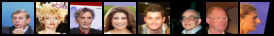

In [9]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb)

Each image has a size of 64x64 pixels and 3 color channels (RGB).

# 3. Third Step: Corruption

Here we begin the actual *diffusion* process, which consists of gradually adding noise to the images in the dataset. These noisy images will then be fed into our model. This process is called *corruption*, or the *"corruption process"*.

In general terms, what our model will predict is the **noise** present in the image—not the image itself. Then, with the predicted noise, we can subtract it during the image generation stage (that is, the step following corruption). Since we want both processes to be **iterative**, we’ll use a tool from the *diffusers* library called a **scheduler**.


In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

A process that adds a small amount of noise at each step,

that is, going from a point $x_{t-1}$ to $x_t$, can be mathematically described as:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad$


$q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1}q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$


where $\mathcal{N}$ represents a normal distribution, $\mathbf{I}$ is the identity matrix, and our *schedule* is controlled by the variance $\{\beta_t \in (0,1)\}^T_{t=1}$.  
In short, we take the sample $\mathbf{x}_{t-1}$, multiply it by the mean of the distribution, $μ_t = \sqrt{1 - \beta_t}x_{t-1}$, and add noise using $\beta_t$.

Thus, our image becomes increasingly noisy, losing its original features as the variable *t* increases.

But let’s think of a case where we want to add noise hundreds of times — that would be very computationally expensive.  
To get around this, we’ll use the **reparameterization trick**:

If we define $α_t = 1 - \beta_t$, $\bar{\alpha}_t = \prod_{s=0}^t \alpha_s$, and the Gaussian noise as $ϵ_0, ... ϵ_{t-1}, ϵ_{t-1} \approx \mathcal{N} (0,1)$,  
we can produce a corrupted sample $x_t$ that does not depend on the previous step, $t-1$:



$\begin{aligned}
x_t \approx q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$

Let’s visualize what happens with $\sqrt{\bar{\alpha}}_t$ and $\sqrt{(1 - \bar{\alpha}}_t$:  
the first variable multiplies our input $x_0$, and the second represents our noise.

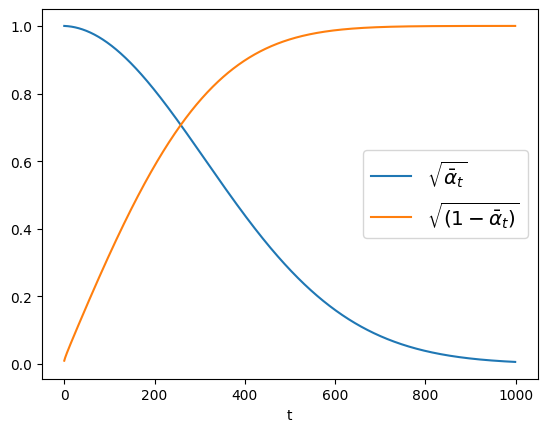

In [11]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.xlabel('t')
plt.legend(fontsize="x-large");

Now, let's add some noise to the dataset images:

Noisy X shape torch.Size([8, 3, 32, 32])


/tmp/ipykernel_114206/3666058215.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


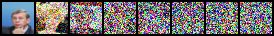

In [15]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb)

<u>Exercise</u>: We can slightly modify our _noise_scheduler_ defined above by now setting values for the beginning and end of $\beta_t$, or even changing its format. Research how to make these changes in the DDPMScheduler function (beta_start, beta_end, and beta_schedule).


Noisy X shape torch.Size([8, 3, 32, 32])


/tmp/ipykernel_114206/3666058215.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


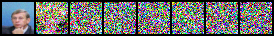

In [16]:
# Beta schedule linear, com início e fim maiores do que o default
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.1)

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb)

Noisy X shape torch.Size([8, 3, 32, 32])


/tmp/ipykernel_114206/3666058215.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


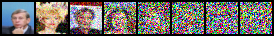

In [19]:
# Beta schedule sigmoidal, com início e fim default (0.0001 -> 0.02)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='sigmoid')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb)

No primeiro caso, observamos que a imagem fica ruidosa mais rapidamente, devido principalmente ao beta inicial 10x maior.

Já no segundo caso, notamos uma transição mais suave ao utilizar o beta schedule sigmoidal ao invés do linear.

#4. Fourth Step: Defining the Model

In this project, since we’re dealing with a diffusion model, we’ll use the most popular neural network architecture for this kind of application: the [U-Net](https://arxiv.org/abs/1505.04597) (looking at the image below, can you tell why it’s called “U-Net”?).

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

Originally designed for medical segmentation problems, the U-Net is well-suited here because it’s an autoencoder that takes in and outputs images without changing their dimensions at the end of the process. In a diffusion model architecture, the U-Net is used in the _denoising_ stage (removing noise from images): it receives the noisy image, reduces its dimensionality (extracting the most important attributes, or _features_, from the input image) in the _downsample_ path—typically using convolutional neural networks (like ResNet, in this case); in the _upsample_ path, it performs convolutions to produce an image containing the predicted noise for the given input.

In short, it’s an excellent architecture for image tasks. Summarized, it follows these steps:

- _Downsample_ stage, which takes the image as input and, at each [ResNet](https://huggingface.co/docs/transformers/model_doc/resnet) block, halves the image size;
- _Upsample_ stage, where the same happens but now doubling the image size at each block;
- A distinctive aspect of the [U-Net](https://arxiv.org/abs/1505.04597) is the skip connections between each step of the _downsample_ and _upsample_ stages.

One point to note is that, with this architecture, the predicted image has the same size as the input image.

Let’s now create our own U-Net in the cell below, using the `UNet2DModel` class from the Diffusers library, which builds the architecture in PyTorch.


In [20]:
from diffusers import UNet2DModel

# Creating the model
model = UNet2DModel(
    sample_size=image_size,  # image resolution
    in_channels=3,  # number of input channels (3 for RGB)
    out_channels=3,  # number of output channels
    layers_per_block=2,  # how many ResNet layers will be used in each UNet block
    block_out_channels=(64, 128, 128, 256),  # the more channels, the more parameters
    down_block_types=(
        "DownBlock2D",  # ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet downsampling block with self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # ResNet upsampling block with self-attention
        "UpBlock2D",
        "UpBlock2D",  # ResNet upsampling block
    ),
)
model.to(device);


The number of ResNet layer blocks can vary according to the size and resolution of the images in the dataset to be used. For 64x64 images, we can try two or three blocks in the downsampling and upsampling stages.

We’ll use the model with a batch of images and random timesteps to check the dimensions of our output:


In [21]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

We can then confirm that the output has the same dimensions as the input:

In [22]:
print('Input dimensions:', xb.shape)

Input dimensions: torch.Size([8, 3, 32, 32])


#5. Fifth Step: Training

Let’s finally train our model! In the cell below we have a standard PyTorch training loop. For each batch of images, we update the network’s weights using an optimizer—here, AdamW with a learning rate of 0.0004.

In summary, for each batch we will:

- Randomly select some timesteps
- Add noise to the samples
- Feed the noisy samples into the model
- Compare the predicted noise with the true noise using MSE as our loss function
- Update the weights using `loss.backward()` and `optimizer.step()`

In addition, we’ll collect the loss log values during training so we can plot them afterward.


If you don’t have a powerful GPU, run the two cells below, which reduce the dataset to only 10,000 images.

In [40]:
small_train_dataset = dataset.shuffle(seed=42).select(range(10000))

In [41]:
train_dataloader = torch.utils.data.DataLoader(
    small_train_dataset, batch_size=batch_size, shuffle=True
)

In addition, we’ll use a tool that visually shows us (as a loading bar) the progress of our training — the `tqdm` library. When was the last time you drank water?

In [23]:
from tqdm import tqdm

In [24]:
# Setting our noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Creating the training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in tqdm(range(15), desc = 'Training'):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Noise to be added to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Selecting a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Adding noise to the clean images according to the noise value at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Making the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculating the loss function
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Updating the model parameters (weights) with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    # Printing progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Training:   0%|          | 0/15 [00:00<?, ?it/s]/home/henriquesouza/diffusion_dgm/.venv/lib/python3.12/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Training:  33%|███▎      | 5/15 [12:15<24:29, 146.96s/it]

Epoch:5, loss: 0.049143206300502215


Training:  67%|██████▋   | 10/15 [24:28<12:14, 146.81s/it]

Epoch:10, loss: 0.04715617474601548


Training: 100%|██████████| 15/15 [36:44<00:00, 146.97s/it]

Epoch:15, loss: 0.046399954309309314


Let’s now visualize the progression of our loss function in two graphs — one with the actual value and another with the application of the log function:

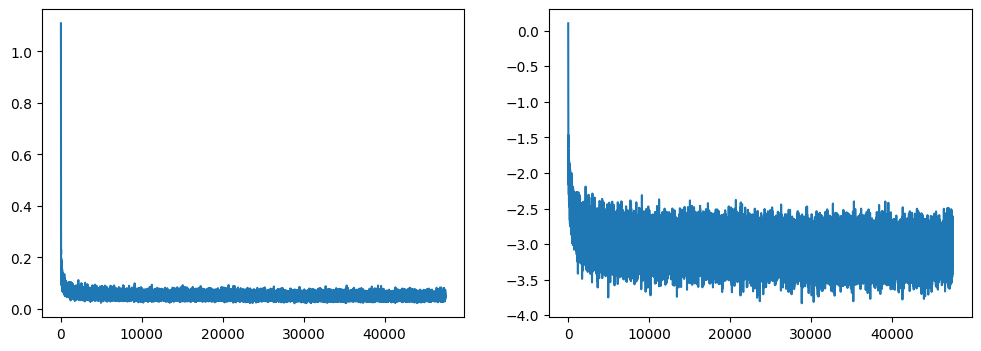

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

#6. Sixth Step: Generating Images
Now for the fun part. With our model trained on the faces dataset, what will the images it generates look like?

First, let’s create our pipeline using the `diffusers` library:


In [26]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

100%|██████████| 1000/1000 [00:04<00:00, 209.93it/s]


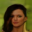

In [27]:
pipeline_output = image_pipe()
pipeline_output.images[0]

Congratulations! You’ve made it this far — and as a reward, you’ve generated your first image using a diffusion model. What do you think of it? Does it resemble any celebrity you know?

Our final task is to save this pipeline so we don’t lose our training progress. You can try setting `safe_serialization` to _True_ to save the pipeline as `safetensors` — a safer way to store your model, although it often causes some errors.


In [28]:
image_pipe.save_pretrained("pipe_v1_32x32_10000", safe_serialization  = False)

Voilà! We now have our model saved, so if we want to generate more faces using it, we don’t need to train it again. Inside the folder created here in Colab, you’ll find the subfolders `scheduler` and `unet`, containing the neural network weights (.bin file) and the configuration files with the hyperparameters used in the project.

Congratulations on making it to the end — which is really just the beginning of it all.


In [29]:
??image_pipe.forward

Object `image_pipe.forward` not found.
